<a href="https://colab.research.google.com/github/mknomics/tradewars/blob/LSTM/Toy_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import zipfile

#within module imports
from numpy import array
from numpy import hstack

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import CuDNNLSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import metrics
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler

#Load data from github
url = 'https://raw.githubusercontent.com/mknomics/tradewars/master/final1268.csv'
df = pd.read_csv(url)
#df.head()
#first row has N/A values - drop this row
#print(df.isna().sum())
df = df.drop(index=0)
period = df['period']
df = df.drop(columns=['x', 'T', 'r2', 's', 'sf', '_merge','period','HS7','pid','month', '_Imonth_2', '_Imonth_3', '_Imonth_4', '_Imonth_5', '_Imonth_6', '_Imonth_7', '_Imonth_8', '_Imonth_9', '_Imonth_10', '_Imonth_11', '_Imonth_12'])

#slice X and Y sets
X = df.iloc[:,1:].values
Y = df.iloc[:,0].values
Y = np.reshape(Y, (Y.shape[0],1))

#scale X and Y
X_scaler = MinMaxScaler(feature_range=(0,1))
Y_scaler = MinMaxScaler(feature_range=(0,1))

scaled_X = pd.DataFrame(X_scaler.fit_transform(X))
scaled_Y = pd.DataFrame(Y_scaler.fit_transform(Y))

# Logic of the slice
Tariff is announced at df.iloc[91:,:].  I originally sliced the pre-announcement period into a training and validation set (as seen below).  But these are not the same shape, which is a problem for LSTM models.  

I then moved away from this slicing scheme and moved towards creating windows in the dataset using TimeSeriesGenerator().  For now, I am using the set, X_fit, Y_fit, which includes all of the pre-treatment data.  But I am aware that there are parameters within TimeSeriesGenerator(), that might allow me to use the full dataset scaled_X , scaled_Y

In [216]:
'''
We will use a rolling window of size=timesteps.  This is used to dynamically split 
data so that the validation set is of size=timesteps.  "timesteps" is then used
in the data generator below

I pick a window = 12 because there are 12 months in a year
'''
timesteps = 12 

def timesplit(scaled_X, scaled_Y, timesteps=True):
    '''
    splits data into sets that can accommodate a windowsize = timesteps
    '''
    #define pre-treatment period
    X_pre = scaled_X.iloc[:90,:].values
    Y_pre = scaled_Y.iloc[:90,:].values

    #define training sets
    X_train = X_pre[0:-(timesteps+2),:]
    Y_train = Y_pre[0:-(timesteps+2),:]

    #define validation sets
    X_validate = X_pre[-(timesteps+1):,:]
    Y_validate = Y_pre[-(timesteps+1):,:]

    #define test set, note that test set cannot be used with a data generator and a window = 12
    #X_test_scaled = X_train.iloc[91:99,:]
    #Y_test_scaled = Y_train.iloc[:,0]

    '''
    After hyperparameter optimization, I want to then fit the model on both sets
    '''
    #Fit set = train + validate
    Y_fit = np.concatenate((Y_train, Y_validate), axis=0)
    X_fit = np.concatenate((X_train, X_validate), axis=0)

    return X_pre, Y_pre, X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit


X_pre, Y_pre, X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit = timesplit(scaled_X, scaled_Y, timesteps=timesteps)
'''
DEPRECIATED: after adding Flat layer to LSTM
# Reshape X and Y to be 3D compatible with LSTM
X_train = X_train.reshape(1,X_train.shape[0], X_train.shape[1])
Y_train = Y_train.reshape(1,Y_train.shape[0], Y_train.shape[1])

X_validate = X_validate.reshape(1,X_validate.shape[0], X_validate.shape[1])
Y_validate = Y_validate.reshape(1,Y_validate.shape[0], Y_validate.shape[1])

X_fit = X_fit.reshape(1,X_fit.shape[0], X_fit.shape[1])
Y_fit = Y_fit.reshape(1,Y_fit.shape[0], Y_fit.shape[1])

X = X.reshape(1,X.shape[0], X.shape[1])
Y = Y.reshape(1,Y.shape[0], Y.shape[1])
'''
print("X_train shape", X_train.shape, "X_validate shape:", X_validate.shape, "X_fit shape:", X_fit.shape, "X shape:", X.shape)
print("Y_train shape", Y_train.shape, "Y_validate shape:", Y_validate.shape, "Y_fit shape", Y_fit.shape, "Y shape", Y.shape)

X_train shape (76, 95) X_validate shape: (13, 95) X_fit shape: (89, 95) X shape: (107, 95)
Y_train shape (76, 1) Y_validate shape: (13, 1) Y_fit shape (89, 1) Y shape (107, 1)


# Using TimeSeriesGenerator to create windows

In [0]:

# define generator
# timesteps are defined above in "data split" section, in order to dynamically split the data to size 
n_features = X_fit.shape[1]

def make_generators(X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit):
    #Create training and validtion generators
    train_generator = TimeseriesGenerator(data=X_train, targets=Y_train, length=timesteps, batch_size=timesteps)
    validation_generator = TimeseriesGenerator(data=X_validate, targets=Y_validate, length=timesteps, batch_size=timesteps)
    #after model selection then fit on training + validation data
    fit_generator = TimeseriesGenerator(data=X_fit, targets=Y_fit, length=timesteps, batch_size=timesteps)
    return train_generator, validation_generator, fit_generator

train_generator, validation_generator, fit_generator = make_generators(X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit)

#prediction model for post treatment
full_generator = TimeseriesGenerator(data=X, targets=Y, length=timesteps, batch_size=timesteps)


In [218]:
print(len(train_generator))
print(X_train.shape[1]/timesteps)

6
7.916666666666667


# Game Plan

**Step 1:** make architecture to overfit data

**Step 2:**  make model choices to create a more parsimonious model. 

**Step 3:** tune the hyperparameters of parsimonious model

## Step 1: make architecture to overfit data
I use an LSTM layer with number of nodes = n_features.  This fully saturates the feature-space of the model.  Logic behind following Steps 1-3 is that I do not want to optimize a model if it does not even fit the data well


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


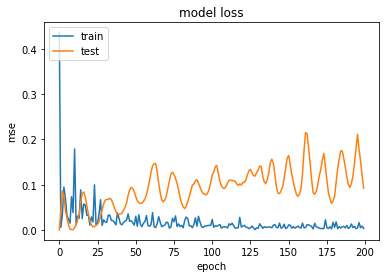

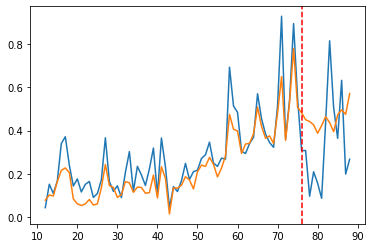

In [219]:
#make model
model = Sequential()
model.add(LSTM(n_features, input_shape=(timesteps, n_features), activation="relu", return_sequences=True))  
model.add(Dropout(0.1))
model.add(Flatten())
#model.add(Dense(timesteps))
model.add(Dense(1)) 

model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=['mean_squared_error'])
# fit model
train_history = model.fit_generator(train_generator, validation_data=validation_generator, steps_per_epoch=1, epochs=200, verbose=0)  

#Evaluate the model

print(train_history.history.keys())
# summarize history for loss
plt.plot(train_history.history['mean_squared_error'])
plt.plot(train_history.history['val_mean_squared_error'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plot predictions vs actual
yhat_val = model.predict_generator(generator=fit_generator)
dt = 1
t = np.arange(0, yhat_val.shape[0], dt)
#scale t accordingly, since first values are not used
t = t+timesteps
plt.plot(t, Y_fit[timesteps:, :], t, yhat_val)
plt.axvline(x=(X_train.shape[0]), color='red', linestyle='--')
plt.show()

# Notes
**Note 1** Model is overfit as expected.  The verticle line in the plot above separates the training and validation sets.  

# Step 2: Make a better model

### Adjusting window size
We notice that variability increases towards the end of the sample.  Such variability is lost when the window size is larger.  We will need to keep this in mind when looking at the test set, if for example, the variability in the test set is greater than in the validation set.  As a first step, I will reduce the window size to 6 months, 3 months and 2 months.

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


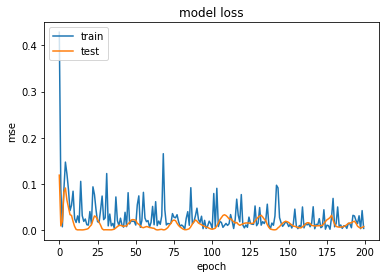

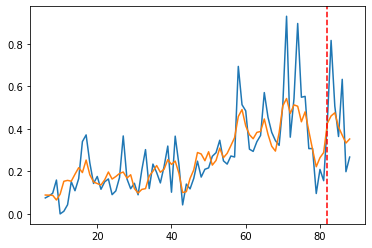

In [221]:
timesteps=6
X_pre, Y_pre, X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit = timesplit(scaled_X, scaled_Y, timesteps=timesteps)
train_generator, validation_generator, fit_generator = make_generators(X_train, Y_train, X_validate, Y_validate, X_fit, Y_fit)


#make model
model = Sequential()
model.add(LSTM(n_features, input_shape=(timesteps, n_features), activation="relu", return_sequences=True))  
model.add(Dropout(0.3))
model.add(Flatten())
#model.add(Dense(timesteps))
model.add(Dense(1)) 

model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=['mean_squared_error'])
# fit model
train_history = model.fit_generator(train_generator, validation_data=validation_generator, steps_per_epoch=1, epochs=200, verbose=0)  

#Evaluate the model

print(train_history.history.keys())
# summarize history for loss
plt.plot(train_history.history['mean_squared_error'])
plt.plot(train_history.history['val_mean_squared_error'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plot predictions vs actual
yhat_val = model.predict_generator(generator=fit_generator)
dt = 1
t = np.arange(0, yhat_val.shape[0], dt)
#scale t accordingly, since first values are not used
t = t+timesteps
plt.plot(t, Y_fit[timesteps:, :], t, yhat_val)
plt.axvline(x=(X_train.shape[0]), color='red', linestyle='--')
plt.show()

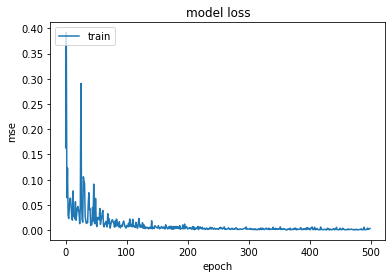

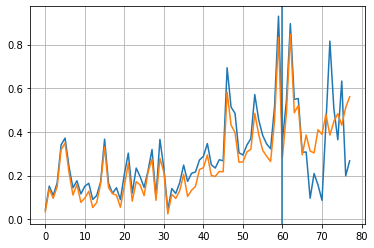

In [0]:
#make model
model = Sequential()
'''
NOTE: TimeseriesGenerator creates a set with length timesteps
'''
model.add(LSTM(n_features, input_shape=(timesteps, n_features), activation="relu", return_sequences=True)) 
#model.add(LSTM(50, batch_input_shape=(None, 1, n_features), activation="relu", return_sequences=True, stateful=True))  
model.add(Dropout(0.1))


'''
NOTE: Adding Flatten solves dimensionality problem but need to better understand implications of Flatten layer
LSTM is a 3 dim object but then Dens layers take 2D is my current understanding.  Still not 100 percent sure.
'''
model.add(Flatten())
model.add(Dense(timesteps))

model.add(Dense(1)) 



#optimizer = SGD(lr=0.001, momentum=0.3, decay=0.001)

model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=['mean_squared_error'])
# fit model
train_history = model.fit_generator(train_generator, steps_per_epoch=1, epochs=500, verbose=0)  
#model.fit(X_train, Y_train , validation_data=(X_validate, Y_validate), epochs=2 , verbose=1) # This model crapped out because training and validation are not same shape

#Evaluate the model

# summarize history for loss
plt.plot(train_history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#model.predict(X_validate)
#print(history.history.keys())
yhat_val = model.predict_generator(generator=fit_generator)

#plot predictions vs actual

dt = 1
t = np.arange(0, yhat_val.shape[0], dt)

plt.plot(t, Y_fit[timesteps:, :], t, yhat_val)
plt.axvline(x=60)

plt.grid(True)

plt.show()